<a href="https://colab.research.google.com/github/Ruchika-11/EVA-7/blob/main/Assignment_5/Session5colab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP Code**


### ***Target:***
Getting the data; setting Transforms, Data Loader and Training and Testing loop


### ***Results:***
Parameters: 6.3M   
Best Training Accuracy: 99.94%        
Best Test Accuracy: 99.33%        

### ***Analysis:***
Model with extremely large number of parameters.
It has over-fitting as well as is not able to meet our requirement of 99.4% accuracy.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.07310313731431961 Batch_id=468 Accuracy=87.55: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0679, Accuracy: 9781/10000 (97.81%)

EPOCH: 2


Loss=0.020024774596095085 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:38<00:00, 12.20it/s]



Test set: Average loss: 0.0355, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.020119285210967064 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0329, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.015970677137374878 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0363, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.015138659626245499 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]



Test set: Average loss: 0.0304, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.0014324671356007457 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0294, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.006819214206188917 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0314, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.003803269239142537 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.0019033191492781043 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:38<00:00, 12.18it/s]



Test set: Average loss: 0.0288, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.0001656435342738405 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0284, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.00036668218672275543 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0282, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.0002094032388413325 Batch_id=468 Accuracy=99.86: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0324, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.000659598910715431 Batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]



Test set: Average loss: 0.0305, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.0005737612373195589 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:38<00:00, 12.22it/s]



Test set: Average loss: 0.0318, Accuracy: 9933/10000 (99.33%)



Text(0.5, 1.0, 'Test Accuracy')

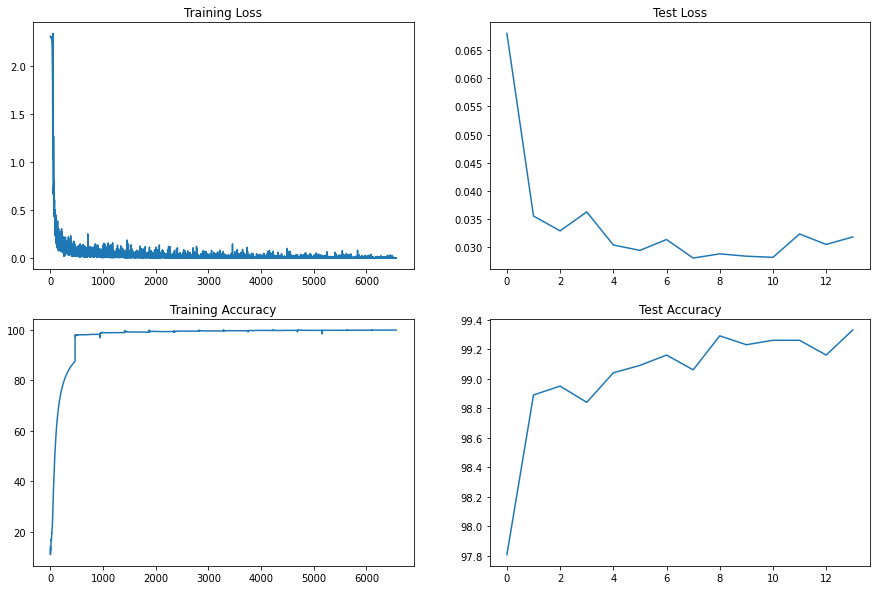

In [7]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")